# This document will implement the Chapter 10 models and exercises but will use pytorch instead of tensorflow and keras
## Fashion NIST Simple NN

In pytorch, instead of creating a model like in tensor flow that is stand alone from APIs. It looks like it is more object oriented and uses a class structure instead. 

First step will be to get the fashion data into a format that can be used with the model itself. This requires the creation of Dataset & Dataloader.

Dataset is responsible for accessing and processing single instances of the data. 

While a Dataloader pulls instaces of the data from the Dataset, collects them in batches and returns them for use in training.

Part of the dataset creation, we will normalize the images to be zero centered as these are more efficient to work with causing training loop to be shorter in runtime.

In [111]:
# Import necessary libraries for Dataset and DataLoader
import torch
import torchvision
import torchvision.transforms as transforms

In [96]:
# Add tensor board support for better visualization of the model we are creating.
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

With pytorch we can use GPU for faster training speed. Figure out if we can with this code.

In [97]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [98]:
investigate_mnist_data_shape = torchvision.datasets.FashionMNIST('Data/FashionMNIST', train=True, transform=transforms.ToTensor(), download=True)

In [99]:
# Investigate the size of the data
investigate_mnist_data_shape.data.shape

torch.Size([60000, 28, 28])

The data is 60_000 images of the shape (28, 28). Thus for the normalized transform we need to have to dimensions for the (mean, std))

In [100]:
# We start by creating a transformer function. This will convert the dataset to a tensor and
# apply the normalization to make it 0 centered and standard deviation around 0.5

mean = 0.5

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # Normalize needs a mean for each channel. Being that this is a grayscale we only have one channel
        transforms.Normalize((0.5,), (0.5,))
    ]    
)

training_set = torchvision.datasets.FashionMNIST('Data/FashionMNIST', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('Data/FashionMNIST', train=False, transform=transform, download=True)

We now have our datasets. As the data was already in torchvision we don't need to explicitly create the classes themselves yet.

Now we need to create a DataLoader that will take in this DataSet for both training and validation

In [101]:
batch_size = 4
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

Generate our class labels as the FashionMNIST data set does not have any labels, just numbers

In [102]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


To make sure the data is looking like how we should expect we should visualize the data we received using MatPlotLib

Trouser Bag Ankle Boot Trouser


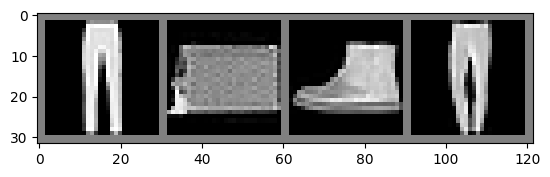

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def display_image(img):
    img = img.mean(dim=0)
    # Remove normalization
    img = img / 2 + 0.5
    # Convert from tensor to np.array
    img_np = img.numpy()
    plt.imshow(img_np, cmap='grey')

# Data iterator of the data loader
data_iter = iter(training_loader)
images, labels = next(data_iter)

# Create a grid of the images to be displayed
img_grid = torchvision.utils.make_grid(images)
display_image(img_grid)

print(' '.join(classes[label] for label in labels))

The labels and the data matches. Sanity Check complete. Good to move forware to setting up the model

In [104]:
# import neural network and activation function libraries
import torch.nn as nn
import torch.nn.functional as F

In [105]:
# Pytorch models are created by inheriting nn.Module
class FashionClassifier(nn.Module):
    def __init__(self):
        super(FashionClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.sequential(x)
        return logits

In [106]:
model = FashionClassifier()
# model = FashionClassifier().to(device)
print(model)

FashionClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


Woot, model looks fairly similar to the model we created in the TensorFlow Document

Now it is time to train the model. In pytorch the steps are more drawn out. Instead of doing fit like in tensorflow we need to list each step in the training loop and make the loop as well

In [107]:
# Get loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Get Optimizer, Using Parameters from tensorflow example
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

For the training loop the general flow is as follows:
1. Get a batch of data from Dataloader
2. Zero optimizer's gradient
3. Query model for predictions
4. Calculate loss between predictions and labels
5. Calculate backward gradients over the learning weights
6. Tell the optimizer to perform 1 step to adjust the weights based on the backwards gradients
7. Report on loss and average loss every to often to see it is working (1_000 batches) and not too often to cause too much non-gpu time.

In [108]:
# One epoch training function
def one_epoch_training(epoch_index, tb_writer):
    '''
        Parameters:
            epoch_index: Specifies the current epoch being trained
            tb_writer: Specifies the TensorBoard Writer for visualization

        Returns:
            Final loss value for epoch
    '''
    running_loss = 0.
    final_loss = 0.
    total_correct = 0
    total_samples = 0

    # Loop through all batches of images 
    for i, data in enumerate(training_loader):
        inputs, labels = data
        # inputs = inputs.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)
        _, predicted = torch.max(predictions, 1)

        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        # Update the running total of correct predictions and samples
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        if i % 1000 == 999:
            final_loss = running_loss / 1000 # loss per batch
            accuracy = 100 * total_correct / total_samples
            print(f' batch {i+1} lost: {final_loss} accuracy: {accuracy}')
            images_trained = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train/accuracy', final_loss, images_trained, accuracy)
            running_loss = 0.

    accuracy = 100 * total_correct / total_samples
    return final_loss, accuracy

In [109]:
# Actual training loop: Equivalent to tensorflow.fit
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

EPOCHS = 30

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, accuracy = one_epoch_training(epoch, writer)

    running_vloss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization
    model.eval()

    # Disable gradient computation and reduce memory consumption
    # Calculate validation loss here
    with torch.no_grad():
        vcorrect = 0
        vsamples = 0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            # vinputs = vinputs.to(device)
            # vlabels = vlabels.to(device)
            vpredictions = model(vinputs)
            _, vpredict = torch.max(vpredictions, 1)
            vloss = loss_fn(vpredictions, vlabels)
            running_vloss += vloss
            vcorrect += (vpredict == vlabels).sum().item()
            vsamples += vlabels.size(0)

    vaccuracy = 100 * vcorrect / vsamples
    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss}, valid {avg_vloss}')
    print(f'ACCURACY train {accuracy}, valid {vaccuracy}')

    writer.add_scalars('Training vs. Validation Loss', {
        'Training' : avg_loss, 'Validation' : avg_vloss
    }, epoch + 1)
    writer.add_scalars('Training vs. Validation Accuracy', {
        'Training' : accuracy, 'Validation' : vaccuracy
    }, epoch + 1)
    writer.flush()

    # Track best performance, and save the best model state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'Models/FashionMNIST/fashion_model_{timestamp}_{epoch}'
        torch.save(model.state_dict(), model_path)
    

EPOCH 1:
 batch 1000 lost: 2.277395451068878 accuracy: 30.275
 batch 2000 lost: 2.0407505815029143 accuracy: 38.3625
 batch 3000 lost: 1.8530051285028457 accuracy: 47.49166666666667
 batch 4000 lost: 1.7587774111032486 accuracy: 53.9625
 batch 5000 lost: 1.7322047610282898 accuracy: 58.05
 batch 6000 lost: 1.7200182992219926 accuracy: 60.97083333333333
 batch 7000 lost: 1.6918615484237671 accuracy: 63.457142857142856
 batch 8000 lost: 1.7067465267181396 accuracy: 65.075
 batch 9000 lost: 1.700732468366623 accuracy: 66.40277777777777
 batch 10000 lost: 1.6908083832263947 accuracy: 67.5275
 batch 11000 lost: 1.6785322519540786 accuracy: 68.55454545454545
 batch 12000 lost: 1.6948302332162857 accuracy: 69.29791666666667
 batch 13000 lost: 1.6750744414329528 accuracy: 70.04615384615384
 batch 14000 lost: 1.6784543936252594 accuracy: 70.66607142857143
 batch 15000 lost: 1.6703153883218764 accuracy: 71.275
LOSS train 1.6703153883218764, valid 1.6768196821212769
ACCURACY train 71.275, valid 7

use tensorboard --lodir="runs/" to view accuracy and loss graphs.

Overall the accuracy is similar to the TensorFlow model.

In [180]:
# Fetch california house data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Using previous housing to be consistent with thje book
housing = fetch_california_housing()
cal_x_train_full, cal_x_test, cal_y_train_full, cal_y_test = train_test_split(
    housing.data, housing.target, random_state=42)
cal_x_train, cal_x_val, cal_y_train, cal_y_val = train_test_split(
    cal_x_train_full, cal_y_train_full, random_state=42)

cal_x_train = torch.Tensor(cal_x_train)
cal_y_train = torch.Tensor(cal_y_train)
cal_x_test = torch.Tensor(cal_x_test)
cal_y_test = torch.Tensor(cal_y_test)
cal_x_val = torch.Tensor(cal_x_val)
cal_y_val = torch.Tensor(cal_y_val)
cal_x_train.shape

torch.Size([11610, 8])

In [185]:
# Make CustomDataSet

class CalHousingDataSet(torch.utils.data.Dataset):
    def __init__(self, features, values):
        self.features = features
        self.values = values

    def __len__(self):
        return len(self.values)

    def __getitem__(self, index):
        feature = self.features[index]
        feature = (feature - feature.mean()) / feature.std()
        value = self.values[index]
        return feature, value
        
cal_training = CalHousingDataSet(cal_x_train, cal_y_train)
cal_validation = CalHousingDataSet(cal_x_val, cal_y_val)

In [186]:
# Make Data Loaders
batch_size = 32
cal_train_dataloader = torch.utils.data.DataLoader(cal_training, batch_size=batch_size, shuffle=True)
cal_val_dataloader = torch.utils.data.DataLoader(cal_validation, batch_size=batch_size, shuffle=False)

In [187]:
# Create the model

class CalHousingPredictor(nn.Module):
    def __init__(self):
        super(CalHousingPredictor, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(8, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

cal_housing_model = CalHousingPredictor()
print(cal_housing_model)

CalHousingPredictor(
  (sequential): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [192]:
# Choose Loss
cal_loss_fn = torch.nn.MSELoss()

# Choose Optimizer
cal_optim_fn = torch.optim.Adam(cal_housing_model.parameters(), lr=0.001)

In [193]:
# One Epoch Functionality
# One epoch training function
def one_epoch_training_regress(epoch_index, tb_writer):
    '''
        Parameters:
            epoch_index: Specifies the current epoch being trained
            tb_writer: Specifies the TensorBoard Writer for visualization

        Returns:
            Final loss value for epoch
    '''
    running_loss = 0.
    final_loss = 0.

    # Loop through all batches of images 
    for i, data in enumerate(cal_train_dataloader):
        inputs, labels = data
        # inputs = inputs.to(device)
        # labels = labels.to(device)

        cal_optim_fn.zero_grad()

        predictions = cal_housing_model(inputs)

        loss = cal_loss_fn(predictions, labels)
        loss.backward()

        cal_optim_fn.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            final_loss = running_loss / 1000 # loss per batch
            print(f' batch {i+1} lost: {final_loss}')
            samples_trained = epoch_index * len(cal_train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', final_loss, samples_trained)
            running_loss = 0.

    return final_loss

In [194]:
# Actual training loop: Equivalent to tensorflow.fit
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/cal_housing_{}'.format(timestamp))

EPOCHS = 30

best_vloss = 1_000_000

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}:')

    # Make sure gradient tracking is on, and do a pass over the data
    cal_housing_model.train(True)
    avg_loss = one_epoch_training_regress(epoch, writer)

    running_vloss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization
    cal_housing_model.eval()

    # Disable gradient computation and reduce memory consumption
    # Calculate validation loss here
    with torch.no_grad():
        for i, vdata in enumerate(cal_val_dataloader):
            vinputs, vlabels = vdata
            # vinputs = vinputs.to(device)
            # vlabels = vlabels.to(device)
            vpredictions = cal_housing_model(vinputs)
            vloss = cal_loss_fn(vpredictions, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(f'LOSS train {avg_loss}, valid {avg_vloss}')

    writer.add_scalars('Training vs. Validation Loss', {
        'Training' : avg_loss, 'Validation' : avg_vloss
    }, epoch + 1)
    writer.flush()

    # Track best performance, and save the best model state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'Models/CalHousing/cal_housing_model_{timestamp}_{epoch}'
        torch.save(cal_housing_model.state_dict(), model_path)
    

EPOCH 1:


/home/blake/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 batch 1000 lost: 1.4577735597752035
 batch 2000 lost: 1.3249137233104558


/home/blake/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 1.3249137233104558, valid 1.3602584600448608
EPOCH 2:
 batch 1000 lost: 1.3298056891150773
 batch 2000 lost: 1.3752771702092141
LOSS train 1.3752771702092141, valid 1.3598235845565796
EPOCH 3:
 batch 1000 lost: 1.379435848876834
 batch 2000 lost: 1.3762845395542682
LOSS train 1.3762845395542682, valid 1.3158090114593506
EPOCH 4:
 batch 1000 lost: 1.381956454642117
 batch 2000 lost: 1.3762726607881486
LOSS train 1.3762726607881486, valid 1.3166735172271729
EPOCH 5:
 batch 1000 lost: 1.4061785711795092
 batch 2000 lost: 1.3817301841564475
LOSS train 1.3817301841564475, valid 1.3332821130752563
EPOCH 6:
 batch 1000 lost: 1.3345778232701122
 batch 2000 lost: 1.392570194265805
LOSS train 1.392570194265805, valid 1.324141025543213
EPOCH 7:
 batch 1000 lost: 1.3348405571430921
 batch 2000 lost: 1.3682498428281398
LOSS train 1.3682498428281398, valid 1.407766580581665
EPOCH 8:
 batch 1000 lost: 1.39646395047009
 batch 2000 lost: 1.4019661042722873
LOSS train 1.4019661042722873, vali

KeyboardInterrupt: 